In [1]:
import sys
import findspark
import pyspark
!pip install folium
import folium
import math
import numpy as np
WhoIsWorking="Daan"
if(WhoIsWorking=="Daan"):
    findspark.init("c:/Users/Eigenaar/spark-3.1.2-bin-hadoop3.2")
else:
    findspark.init("C:\\spark-3.1.2-bin-hadoop3.2\\spark-3.1.2-bin-hadoop3.2")

You should consider upgrading via the 'c:\users\eigenaar\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import avg
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
from pyspark.sql.functions import col
from collections import Counter
from pyspark.sql.functions import count
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:

#Creating schema's
schema_pubs = StructType([
    StructField("Food Standard Agency's ID", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("address", StringType(), nullable=True),
    StructField("postcode", StringType(), nullable=True),
    StructField("easting", DoubleType(), nullable=True),
    StructField("northing", DoubleType(), nullable=True),
    StructField("latitude", DoubleType(), nullable=False),
    StructField("longitude", DoubleType(), nullable=False),
    StructField("local_authority", StringType(), nullable=True)

])

In [5]:
# importing data 

### casualtiesData_df geeft meer info over het slachtoffer
if(WhoIsWorking=="Daan"):
    casualtiesData_df = spark.read.format('csv').option('header', True).load('Kaggle_datasets/Casualties0514.csv')
    accidentData_df = spark.read.format('csv').option('header',True).load('Kaggle_datasets/Accidents0514.csv')
    pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
else:
    accidentData_df = spark.read.format('csv').option('header',True).load('../../../Desktop/Data mining/Accidents0514.csv')
    pubsData_df = spark.read.format('csv').option('header',False).schema(schema_pubs).load('open_pubs.csv')
    casualtiesData_df = spark.read.format('csv').option('header', True).load('../../../Desktop/Data mining/Casualties0514.csv')

In [6]:
### Filter de pub data set
counterRowsBeforePubs=pubsData_df.count()
pubsData_df=pubsData_df.dropna(subset=["latitude","longitude"])
print(counterRowsBeforePubs-pubsData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")
### nutteloze kolommen zoals Pedestrian_Crossing,Special_Condition_at_site, Carriageway_Hazards,  want volgens Kaggle hebben bijna alle records dezelfde data dus veel gaat deze kolom ons niet opleveren alleen maar een langere run time. heb ook Location_Northing_OSGR, Location_Easting_OSGR, Local_Authority_(District), Local_Authority_(Highway)1st_Road_Class, 1st_Road_Number, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities
accidentData_df = accidentData_df.drop("Pedestrian_Crossing", "Special_Condition_at_site","Local_Authority_(Highway)", "Carriageway_Hazards","Location_Northing_OSGR", "Location_Easting_OSGR", "Local_Authority_(District)", "Local_Authority_(Highway)1st_Road_Class", "1st_Road_Number", "2nd_Road_Class", "2nd_Road_Number", "Pedestrian_Crossing-Human_Control", "Pedestrian_Crossing-Physical_Facilities")
### In casualtiesData heb ik ook een paar kolommen verwijderd => Pedestian_Location, Pedestrian_Movement, Bus_or_Coach_, Vehicle_Reference, Casualty_Reference, Age_Band_of_Casualty, Pedestrian_Road_Maintenance_Worker, Casualty_Home_Area_Type
casualtiesData_df = casualtiesData_df.drop("Pedestian_Location", "Pedestrian_Movement", "Bus_or_Coach_Passenger", "Vehicle_Reference", "Casualty_Reference", "Age_Band_of_Casualty", "Pedestrian_Road_Maintenance_Worker","Casualty_Home_Area_Type" )
print("Kolommen Vehicle_Reference en Casualty_Reference zijn zeer nuttige gegevens maar die waarden komen precies niet overeen met die tabel op Kaggle dus heb ze weggelaten. Kan dat ik verkeerd ben maar heb niets gevonden.")


146  rijen zijn verwijderd omdat ze lege waarden hadden.
Kolommen Vehicle_Reference en Casualty_Reference zijn zeer nuttige gegevens maar die waarden komen precies niet overeen met die tabel op Kaggle dus heb ze weggelaten. Kan dat ik verkeerd ben maar heb niets gevonden.


In [7]:
### Filter de accident data set
counterRowsBeforePubs=accidentData_df.count()
accidentData_df=accidentData_df.na.drop()
print(counterRowsBeforePubs-accidentData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")

### Filter de casaulties data
counterRowsBeforeCasaul=casualtiesData_df.count()
casualtiesData_df=casualtiesData_df.na.drop()
print(counterRowsBeforeCasaul-casualtiesData_df.count()," rijen zijn verwijderd omdat ze lege waarden hadden.")


120599  rijen zijn verwijderd omdat ze lege waarden hadden.
0  rijen zijn verwijderd omdat ze lege waarden hadden.


In [8]:
accidentData_df.show(5, vertical=True)

-RECORD 0----------------------------------------------------
 Accident_Index                              | 200501BS00001 
 Longitude                                   | -0.191170     
 Latitude                                    | 51.489096     
 Police_Force                                | 1             
 Accident_Severity                           | 2             
 Number_of_Vehicles                          | 1             
 Number_of_Casualties                        | 1             
 Date                                        | 04/01/2005    
 Day_of_Week                                 | 3             
 Time                                        | 17:42         
 1st_Road_Class                              | 3             
 Road_Type                                   | 6             
 Speed_limit                                 | 30            
 Junction_Detail                             | 0             
 Junction_Control                            | -1            
 Light_C

In [9]:
pubsData_df.show(5, vertical=True)

-RECORD 0-----------------------------------------
 Food Standard Agency's ID | 24                   
 name                      | Angel Inn            
 address                   | 43 Friars Street,... 
 postcode                  | CO10 2AG             
 easting                   | 587207.0             
 northing                  | 241058.0             
 latitude                  | 52.036312            
 longitude                 | 0.727924             
 local_authority           | Babergh              
-RECORD 1-----------------------------------------
 Food Standard Agency's ID | 33                   
 name                      | Ark Bar Restaurant   
 address                   | Ark Bar And Resta... 
 postcode                  | CO11 1RH             
 easting                   | 610194.0             
 northing                  | 233329.0             
 latitude                  | 51.958698            
 longitude                 | 1.057832             
 local_authority           | Ba

In [10]:
casualtiesData_df.show(5, vertical=True)

-RECORD 0----------------------------
 Accident_Index      | 200501BS00001 
 Casualty_Class      | 3             
 Sex_of_Casualty     | 1             
 Age_of_Casualty     | 37            
 Casualty_Severity   | 2             
 Pedestrian_Location | 1             
 Car_Passenger       | 0             
 Casualty_Type       | 0             
-RECORD 1----------------------------
 Accident_Index      | 200501BS00002 
 Casualty_Class      | 2             
 Sex_of_Casualty     | 1             
 Age_of_Casualty     | 37            
 Casualty_Severity   | 3             
 Pedestrian_Location | 0             
 Car_Passenger       | 0             
 Casualty_Type       | 11            
-RECORD 2----------------------------
 Accident_Index      | 200501BS00003 
 Casualty_Class      | 1             
 Sex_of_Casualty     | 1             
 Age_of_Casualty     | 62            
 Casualty_Severity   | 3             
 Pedestrian_Location | 0             
 Car_Passenger       | 0             
 Casualty_Ty

In [11]:
#Creating Table
pubsData_df.registerTempTable('pubsTable')
accidentData_df.registerTempTable('accidentTable')
casualtiesData_df.registerTempTable('casualtiesTable')
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)#Running Query
#Running Query
df1 = sqlContext.sql("SELECT COUNT(local_authority) as count,local_authority from pubsTable group by local_authority order by count")
df2 = sqlContext.sql("SELECT COUNT(Number_of_Casualties) as count_casulties,SPEED_LIMIT FROM accidentTable group by SPEED_LIMIT order by SPEED_LIMIT")
## type sql dataframe .collect to get list

[4, 2, 16160, 983411, 128365, 49398, 229611, 113047]


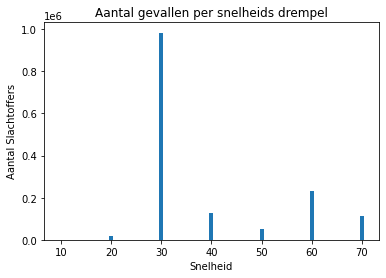

In [12]:
list_casulties_speed=[]
list_speed_casulties=[]
for x in df2.collect():
    list_casulties_speed.append(x[0])
    list_speed_casulties.append(int(x[1]))
print(list_casulties_speed)
plt.bar(list_speed_casulties,list_casulties_speed)
plt.title("Aantal gevallen per snelheids drempel")
plt.xlabel('Snelheid')
plt.ylabel('Aantal Slachtoffers')
plt.show()

In [13]:
local_authority=[]
for row in df1.orderBy("local_authority").collect():
    local_authority.append(row.local_authority)
print(local_authority)

['Aberdeen City', 'Aberdeenshire', 'Adur', 'Allerdale', 'Amber Valley', 'Angus', 'Argyll and Bute', 'Arun', 'Ashfield', 'Ashford', 'Aylesbury Vale', 'Babergh', 'Barking and Dagenham', 'Barnet', 'Barnsley', 'Barrow-in-Furness', 'Basildon', 'Basingstoke and Deane', 'Bassetlaw', 'Bath and North East Somerset', 'Bedford', 'Bexley', 'Birmingham', 'Blaby', 'Blackburn with Darwen', 'Blackpool', 'Blaenau Gwent', 'Bolsover', 'Bolton', 'Boston', 'Bournemouth, Christchurch and Poole', 'Bracknell Forest', 'Bradford', 'Braintree', 'Breckland', 'Brent', 'Brentwood', 'Bridgend', 'Brighton and Hove', 'Bristol, City of', 'Broadland', 'Bromley', 'Bromsgrove', 'Broxbourne', 'Broxtowe', 'Burnley', 'Bury', 'Caerphilly', 'Calderdale', 'Cambridge', 'Camden', 'Cannock Chase', 'Canterbury', 'Cardiff', 'Carlisle', 'Carmarthenshire', 'Castle Point', 'Central Bedfordshire', 'Ceredigion', 'Charnwood', 'Chelmsford', 'Cheltenham', 'Cherwell', 'Cheshire East', 'Cheshire West and Chester', 'Chesterfield', 'Chichester'

In [14]:
choose_local_authority = widgets.Dropdown(
    options=local_authority,
    value='Isles of Scilly',
    description='Authority:',
)

def load_map_points(local_authority):
    df1 = sqlContext.sql("SELECT * from pubsTable where local_authority='"+local_authority+"'")
    local_authority_coordinates = (df1.collect()[0].latitude,df1.collect()[0].longitude)
    map = folium.Map(location=local_authority_coordinates, zoom_start=11.5)
    ## testing 
    counter=0
    for row in df1.collect():
        folium.Marker(location = [row.latitude,row.longitude],popup=row.name).add_to(map)
    display(map)
def on_change(change):
    load_map_points(change)
interact(on_change, change=choose_local_authority);

interactive(children=(Dropdown(description='Authority:', index=164, options=('Aberdeen City', 'Aberdeenshire',…

In [15]:
### twee dataframes in één dataframe joinen m.b.v. ID(Accident_Index). Beide dataframes hebben evenveel records.
joined = accidentData_df.alias("A").join(casualtiesData_df.alias("B"),col("A.Accident_Index") == col("B.Accident_Index"),"inner").select(col("A.Accident_Index"), col("A.Longitude"),col("A.Latitude"), col("A.Police_Force"), col("A.Accident_Severity"), col("A.Number_of_Vehicles"), col("A.Number_of_Casualties"), col("A.Date"), col("A.Day_of_Week"),col("A.Time"), col("A.1st_Road_Class"), col("A.Road_Type"), col("A.Speed_limit"), col("A.Junction_Detail"), col("A.Junction_Control"), col("A.Light_Conditions"), col("A.Weather_Conditions"), col("A.Road_Surface_Conditions"), col("A.Special_Conditions_at_Site"), col("A.Urban_or_Rural_Area"), col("A.Did_Police_Officer_Attend_Scene_of_Accident"), col("A.LSOA_of_Accident_Location"), col("B.Casualty_Class"), col("B.Sex_of_Casualty"), col("B.Age_of_Casualty"), col("B.Casualty_Severity"), col("B.Pedestrian_Location"), col("B.Car_Passenger"), col("B.Casualty_Type")).toDF("Accident_Index", "Longitude","Latitude","Police_Force", "Accident_Severity","Number_of_Vehicles", "Number_of_Casualties", "Date", "Day_of_Week","Time","1st_Road_Class", "Road_Type", "Speed_limit","Junction_Detail", "Junction_Control","Light_Conditions", "Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site","Urban_or_Rural_Area", "Did_Police_Officer_Attend_Scene_of_Accident", "LSOA_of_Accident_Location","Casualty_Class","Sex_of_Casualty","Age_of_Casualty","Casualty_Severity","Pedestrian_Location","Car_Passenger","Casualty_Type")

In [ ]:
### Soorten voertuigen

joined.groupby("Casualty_Type").count().show()

In [ ]:
joined = joined.where("Casualty_Type!=16")
joined = joined.where("Casualty_Type!=17")
joined = joined.where("Casualty_Type!=18")
joined = joined.where("Casualty_Type!=8")
joined = joined.where("Casualty_Type!=10")
joined = joined.where("Casualty_Type!=11")
joined = joined.where("Casualty_Type!=19")
joined = joined.where("Casualty_Type!=20")
joined = joined.where("Casualty_Type!=21")
joined = joined.where("Casualty_Type!=90")
joined = joined.where("Casualty_Type!=98")

In [ ]:
### Casualty Class
joined.groupby("Casualty_Class").count().show()
print("Casualty_Class geeft aan of de persoon in kwestie een passagier(2), bestuurder van een voertuig(1) of een voetganger(3) is. Aangezien wij opzoek zijn naar accidenten die werden veroorzaakt door dronken mensen, lijkt het mij onwaarschijnlijk dat passagiers van voertuigen de oorzaak kunnen zijn van een accident dus ik dacht misschien Casualty_Class(2) weglaten?")
joined = joined.where("Casualty_Class!= 2")

In [18]:
### Leeftijd
joined.groupby("Age_of_Casualty").count().show(20)
print("Er zitten hier records van kinderen 3, 8 jaar enzo. in die andere excel bestand die jij hebt gestuurd was alle info over 16+ mensen. Dus hier weeral al die kinderen verwijderen? Age_of_Casualty met waarde -1 zijn gevallen waar de leeftijd niet gekend is")

+---------------+-----+
|Age_of_Casualty|count|
+---------------+-----+
|             51|17405|
|              7| 5068|
|             54|14564|
|             -1|24689|
|             15|11704|
|             11|11852|
|             29|30037|
|             69| 5586|
|             42|26361|
|             73| 4721|
|             87| 1684|
|             64| 7934|
|              3| 3129|
|             30|34053|
|             34|26827|
|             59|11554|
|              8| 5730|
|             28|31712|
|             22|39418|
|             85| 2518|
+---------------+-----+
only showing top 20 rows

Er zitten hier records van kinderen 3, 8 jaar enzo. in die andere excel bestand die jij hebt gestuurd was alle info over 16+ mensen. Dus hier weeral al die kinderen verwijderen? Age_of_Casualty met waarde -1 zijn gevallen waar de leeftijd niet gekend is


In [19]:
joined = joined.where("Age_of_Casualty >= 16")

In [20]:
def sort_age(age):
    age = int(age)
    if 16 <= age < 25:
        return "16-24"
    elif 25 <= age < 30:
        return "25-29"
    elif 30<=age <35:
        return "30-34"
    elif 35<= age <40:
        return "35-39"
    elif 40<= age <50:
        return "40-49"
    elif 50<= age <60:
        return "50-59"
    else:
        return "+60"


joined = joined.withColumn("Age_of_Casualty", col("Age_of_Casualty").cast("int"))
joined = joined.withColumnRenamed("1st_Road_Class", "First_Road_Class")
joined2 = joined.rdd.map(lambda x: (x.Accident_Index, x.Longitude, 
                                    x.Latitude, x.Police_Force, x.Accident_Severity, x.Number_of_Vehicles, 
                                    x.Number_of_Casualties, x.Date, x.Day_of_Week, x.Time, x.First_Road_Class, 
                                    x.Road_Type, x.Speed_limit, x.Junction_Detail, x.Junction_Control, x.Light_Conditions, 
                                    x.Weather_Conditions,
                                    x.Road_Surface_Conditions, x.Special_Conditions_at_Site,
                                    x.Urban_or_Rural_Area, x.Did_Police_Officer_Attend_Scene_of_Accident, x.LSOA_of_Accident_Location, x.Casualty_Class, x.Sex_of_Casualty, x.Age_of_Casualty, x.Casualty_Severity, x.Pedestrian_Location, x.Car_Passenger, x.Casualty_Type, sort_age(x.Age_of_Casualty)))

joined2 = joined2.toDF(["Accident_Index", "Longitude" , "Latitude" , "Police_Force" , "Accident_Severity" ,
       "Number_of_Vehicles" , "Number_of_Casualties" , "Date" , "Day_of_Week" , "Time" , "1st_Road_Class" , "Road_Type" , "Speed_limit" , "Junction_Detail" , "Junction_Control" , "Light_Conditions" , "Weather_Conditions" , "Road_Surface_Conditions" , "Special_Conditions_at_Site" , "Urban_or_Rural_Area" ,
       "Did_Police_Officer_Attend_Scene_of_Accident" , "LSOA_of_Accident_Location" , "Casualty_Class" , "Sex_of_Casualty" , 
       "Age_of_Casualty" , "Casualty_Severity" , "Pedestrian_Location" , "Car_Passenger" , "Casualty_Type" , "Age_Cat"])

Py4JJavaError: An error occurred while calling o133.javaToPython.
: java.lang.OutOfMemoryError: Java heap space


In [ ]:
joined2.show(20, vertical= True)

In [ ]:
### Aantal accidenten per leeftijdscategorie
cat = joined2.groupby("Age_Cat").count().toDF("Age_Cat", "count")
age_cat=[]
age_cat_amount=[]

In [ ]:
for x in cat.collect():
    age_cat.append(x[0])
    age_cat_amount.append(int(x[1]))
print(age_cat)

In [ ]:
plt.bar(age_cat,age_cat_amount)
plt.title('Aantal accidenten per leeftijdscategorie')

In [ ]:
### Aantal accidenten per Leeftijdscategorie en ernstigheid van het incident
cat2 = joined2.groupby("Age_Cat", "Accident_Severity").count().toDF("Age_Cat", "Accident_Severity", "count").orderBy(asc("Accident_Severity"))

In [ ]:
age_cat=[]
age_cat_amount=[]
severity1=[]
severity2=[]
severity3=[]
amount1=[]
amount2=[]
amount3=[]
for x in cat2.collect():
    if x[0] == "Child" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "Child" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "Child" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "16-24" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "16-24" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "16-24" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "25-34" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "25-34" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "25-34" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "35-44" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "35-44" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "35-44" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "45-60" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "45-60" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "45-60" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "+60" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "+60" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "+60" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "Unknown" and x[1]== 1:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "Unknown" and x[1]== 2:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])
    elif x[0] == "Unknown" and x[1]== 3:
        age_cat.append(x[0])
        age_cat_amount.append(x[2])
        severity.append(x[1])

Kijken naar de accidenten doorheen de tijd

In [117]:
ListOfDays=sqlContext.sql("SELECT Day_of_Week from accidentTable group by Day_of_Week").collect()
Yearslider=widgets.IntSlider(
    min=min(ListOfYears)[0],
    max=max(ListOfYears) [0],
    description='Day:',
)
intresantColoms=("Police_Force","Accident_Severity","Number_of_Vehicles","Number_of_Casualties")
def f(x):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, axs = plt.subplots(math.ceil((len(intresantColoms)/2)),2)
    fig.suptitle('Het aantal voertuigen, gewonden, ergte en politie aanwezigen per soort voor Dag:'+str(x))
    for indx,onderwerp in enumerate(intresantColoms):
        ListOfDays=sqlContext.sql("SELECT "+onderwerp+",count("+onderwerp+") as aantal from accidentTable where Day_of_Week="+str(x)+" group by "+onderwerp+" order by "+onderwerp).collect()
        NumberList=[]
        BarList=[]
        for row in ListOfDays:
            NumberList.append((row[0]))
            BarList.append(row[1])
        axs[math.ceil(indx/2)-1,indx%2].bar(NumberList,BarList)
        axs[math.ceil(indx/2)-1,indx%2].set_title(onderwerp)
    return x
interact(f, x=Yearslider);

interactive(children=(IntSlider(value=1, description='Day:', max=7, min=1), Output()), _dom_classes=('widget-i…

[ 4.96714153e-01 -1.38264301e-01  6.47688538e-01  1.52302986e+00
 -2.34153375e-01 -2.34136957e-01  1.57921282e+00  7.67434729e-01
 -4.69474386e-01  5.42560044e-01 -4.63417693e-01 -4.65729754e-01
  2.41962272e-01 -1.91328024e+00 -1.72491783e+00 -5.62287529e-01
 -1.01283112e+00  3.14247333e-01 -9.08024076e-01 -1.41230370e+00
  1.46564877e+00 -2.25776300e-01  6.75282047e-02 -1.42474819e+00
 -5.44382725e-01  1.10922590e-01 -1.15099358e+00  3.75698018e-01
 -6.00638690e-01 -2.91693750e-01 -6.01706612e-01  1.85227818e+00
 -1.34972247e-02 -1.05771093e+00  8.22544912e-01 -1.22084365e+00
  2.08863595e-01 -1.95967012e+00 -1.32818605e+00  1.96861236e-01
  7.38466580e-01  1.71368281e-01 -1.15648282e-01 -3.01103696e-01
 -1.47852199e+00 -7.19844208e-01 -4.60638771e-01  1.05712223e+00
  3.43618290e-01 -1.76304016e+00  3.24083969e-01 -3.85082280e-01
 -6.76922000e-01  6.11676289e-01  1.03099952e+00  9.31280119e-01
 -8.39217523e-01 -3.09212376e-01  3.31263431e-01  9.75545127e-01
 -4.79174238e-01 -1.85658

#Ongevallen per leeftijds categorie van de verongelukte op omgevings factoren

In [16]:
joinAccidentsCasulties = sqlContext.sql('SELECT * from accidentTable right join casualtiesTable on casualtiesTable.Accident_Index==accidentTable.Accident_Index')

In [17]:
joinAccidentsCasulties.show(5, vertical=True)

-RECORD 0----------------------------------------------------
 Accident_Index                              | 201220T025922 
 Longitude                                   | -1.877646     
 Latitude                                    | 52.465997     
 Police_Force                                | 20            
 Accident_Severity                           | 3             
 Number_of_Vehicles                          | 2             
 Number_of_Casualties                        | 1             
 Date                                        | 30/05/2012    
 Day_of_Week                                 | 4             
 Time                                        | 14:40         
 1st_Road_Class                              | 3             
 Road_Type                                   | 6             
 Speed_limit                                 | 30            
 Junction_Detail                             | 3             
 Junction_Control                            | 4             
 Light_C

In [18]:
ListAccidentsCasulties=joinAccidentsCasulties.select("Age_of_Casualty").distinct().sort("Age_of_Casualty").collect()

In [ ]:
Ageslider=widgets.IntSlider(
    min=min(ListAccidentsCasulties)[0],
    max=max(ListAccidentsCasulties)[0],
    description='Age:',
)
intresantColoms=("Light_Conditions","Weather_Conditions","Road_Type","Time","Day_of_Week")
def createArray(dictionary):
    values=[]
    for row in dictionary:
        if not(row[0]==None):
            values.append(row[0])
        else:
            values.append(0)
    return values
def f(x):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig, axs = plt.subplots(3,2)
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[4]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[4]).collect()
    axs[0,0].hist(createArray(colomForGraph),density=False, bins=7)
    axs[0,0].set_title("Hoeveel ongelukken per dag")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[0]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[0]).collect()
    axs[0,1].hist(createArray(colomForGraph))
    axs[0,1].set_title("Hoeveel ongelukken per licht type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[1]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[1]).collect()
    axs[1,0].hist(createArray(colomForGraph))
    axs[1,0].set_title("Hoeveel ongelukken per weer type")
    colomForGraph=joinAccidentsCasulties.select(intresantColoms[2]).filter("Age_of_Casualty="+str(x)).sort(intresantColoms[2]).collect()
    axs[1,1].hist(createArray(colomForGraph))
    axs[1,1].set_title("Hoeveel ongelukken per road type")
    return x
interact(f, x=Ageslider);

interactive(children=(IntSlider(value=0, description='Age:', max=99, min=-1), Output()), _dom_classes=('widget…

##Gemiddelde afstand dichstbezijne bar en ongeval
Gebruik maken van Haversine formula formule